[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Practical 1: More dogs and cats!

This time, you are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. You will need to adapt the code from lesson 1 to this new task, i.e. a classification with 37 categories.

##  Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
%matplotlib inline

In [2]:
torch.__version__

'2.0.0'

In [3]:
import sys
sys.version

'3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]'

Check if GPU is available and if not change the [runtime](https://jovianlin.io/pytorch-with-gpu-in-google-colab/).

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Downloading the data

The data given on the website [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) is made of two files: `images.tar.gz` and `annotations.tar.gz`. We first need to download and decompress these files.

Depending if you use google colab or your own computer, you can adapt the code below to choose where to store the data.

To see where you are, you can use the standard unix comands:

In [5]:
%pwd

'/kaggle/working'

If you want to change to a directory to store your data:

In [6]:
# %cd #path

In [7]:
# %pwd

In [8]:
%mkdir data
# the line below needs to be adapted if not running on google colab 
%cd ./data/

/kaggle/working/data


In [9]:
%pwd

'/kaggle/working/data'

Now that you are in the right directory, you can download the data:

In [10]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2023-10-28 16:55:18--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2023-10-28 16:55:18--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-10-28 16:55:18--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

and uncompress it:

In [11]:
!tar zxvf images.tar.gz
!tar zxvf annotations.tar.gz

images/
images/boxer_16.jpg
images/chihuahua_165.jpg
images/pug_183.jpg
images/english_setter_1.jpg
images/chihuahua_170.jpg
images/english_cocker_spaniel_17.jpg
images/samoyed_39.jpg
images/Egyptian_Mau_62.jpg
images/samoyed_36.jpg
images/german_shorthaired_3.jpg
images/Ragdoll_183.jpg
images/British_Shorthair_64.jpg
images/american_pit_bull_terrier_57.jpg
images/beagle_120.jpg
images/american_bulldog_174.jpg
images/chihuahua_101.jpg
images/shiba_inu_136.jpg
images/Abyssinian_136.jpg
images/Siamese_201.jpg
images/Abyssinian_85.jpg
images/saint_bernard_145.jpg
images/Siamese_63.jpg
images/leonberger_164.jpg
images/Maine_Coon_126.jpg
images/samoyed_51.jpg
images/Birman_15.jpg
images/english_cocker_spaniel_181.jpg
images/english_cocker_spaniel_128.jpg
images/leonberger_133.jpg
images/english_cocker_spaniel_6.jpg
images/miniature_pinscher_119.jpg
images/american_pit_bull_terrier_27.jpg
images/Abyssinian_37.jpg
images/Bombay_91.jpg
images/Egyptian_Mau_6.jpg
images/Maine_Coon_173.jpg
images

Check that everything went correctly!

In [12]:
%ls

annotations/  annotations.tar.gz  images/  images.tar.gz


## Warning

If you are running this notebook on your own computer, you need to download the data only once. If you want to run this notebook a second time, you can safely skip this section and the section below as your dataset will be stored nicely on your computer.

If you are running this notebook on google colab, you need to download the data and to do the data wrangling each time you are running this notebook as data will be cleared once you log off.

## 1. Exercise: data wrangling

You will first need to do a bit of [data wrangling](https://en.wikipedia.org/wiki/Data_wrangling) to organize your dataset in order to use the PyTorch `dataloader`.

If you want to understand how the files are organized, have a look at the `README` file in the folder `annotations`.

First, we need to split the dataset in a test set and train/validation set. For this, we can use the files `annotations/test.txt` and `annotations/trainval.txt` containing the names of images contained in the test and train/validation sets of the original paper.

In [13]:
!head annotations/test.txt

Abyssinian_201 1 1 1
Abyssinian_202 1 1 1
Abyssinian_204 1 1 1
Abyssinian_205 1 1 1
Abyssinian_206 1 1 1
Abyssinian_207 1 1 1
Abyssinian_20 1 1 1
Abyssinian_210 1 1 1
Abyssinian_212 1 1 1
Abyssinian_213 1 1 1


In [14]:
!head annotations/trainval.txt

Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1
Abyssinian_104 1 1 1
Abyssinian_105 1 1 1
Abyssinian_106 1 1 1
Abyssinian_107 1 1 1
Abyssinian_108 1 1 1
Abyssinian_109 1 1 1


Above you see that the authors of the original paper made a partition of the dataset: `./images/Abyssinian_201.jpg` is in the test set while `./images/Abyssinian_100.jpg` is in the train/validation set and so on.

BTW, it you wonder what Abyssinian means, it is explained [here](https://en.wikipedia.org/wiki/Abyssinian_cat)

We first create two directories where we will put images form the test and trainval sets.

In [15]:
%mkdir test
%mkdir trainval

In [16]:
%ls

annotations/  annotations.tar.gz  images/  images.tar.gz  test/  trainval/


Now it's your turn!

All the images are in the `./images/` folder and you want to store the data according to the following structure:
```bash
.
├── test
|   └── Abyssinian # contains images of Abyssinian from the test set
|   └── Bengal # contains images of Bengal from the test set
|    ... 
|   └── american_bulldog # contains images of american bulldog from the test set
|    ...
├── trainval
|   └── Abyssinian # contains images of Abyssinian from the trainval set
|   └── Bengal # contains images of Bengal from the trainval set
|    ...
|   └── american_bulldog # contains images of american bulldog from the trainval set
|    ...
```

Note that all images wiht a name starting with a majuscule is a cat and all images with a name starting with a minuscule is a dog.

So here is one way to achieve your task: you will read the `./annotations/test.txt` file line by line; from each line, you will extract the name of the corresponding file and then copy it from the `./images/filename_##.jpg` to `./test/filename/filename_##.jpg`, where `##` is a number.

Then you'll do the same thing for `trainval.txt` file.

Below is a little piece of code to show you how to open a file and read it line by line:

In [17]:
with open('./annotations/test.txt') as fp:
    line = fp.readline()
    while line:
        f,_,_,_ = line.split(' ')
        print(f)
        line = fp.readline()
        break

Abyssinian_201


In order to remove the `_201` in the example above, you can use the `re` [regular expression lib](https://docs.python.org/3.6/library/re.html) as follows:

In [18]:
import re
pat = re.compile(r'_\d')
res,_ = pat.split(f)
print(res)

Abyssinian


This small piece of code might be useful:

In [19]:
# create directory if it does not exist
def check_dir(dir_path):
    dir_path = dir_path.replace('//','/')
    os.makedirs(dir_path, exist_ok=True)

Some more hints:
- for moving files around you can use the `shutil` lib, see [here](https://docs.python.org/3.6/library/shutil.html#shutil.copy)
- you can use `os.path.join`
- have a look at python [f-string](https://cito.github.io/blog/f-strings/)

In [20]:
import shutil

In [21]:
# Here your code for test
path_test_dataset = 'test/'
with open('./annotations/test.txt') as fp:
    line = fp.readline()
    while line:
        f,_,_,_ = line.split(' ')
        res,_ = pat.split(f)
        path = os.path.join(path_test_dataset, res)
        check_dir(path)
        shutil.copy(f'./images/{f}.jpg',os.path.join(path,f'{f}.jpg'))
        line = fp.readline()
        

In [22]:
# Here your code for train
# Here your code for test
path_train_dataset = 'train/'
with open('./annotations/test.txt') as fp:
    line = fp.readline()
    while line:
        f,_,_,_ = line.split(' ')
        res,_ = pat.split(f)
        path = os.path.join(path_train_dataset, res)
        check_dir(path)
        shutil.copy(f'./images/{f}.jpg',os.path.join(path,f'{f}.jpg'))
        line = fp.readline()
        

## Data processing

In [23]:
%cd ..

/kaggle/working


In [24]:
%ls
%cd data/
%ls

__notebook__.ipynb  data/
/kaggle/working/data
annotations/        images/        test/   trainval/
annotations.tar.gz  images.tar.gz  train/


Now you are ready to redo what we did during lesson 1.

Below, you give the path where the data is stored. If you are running this code on your computer, you should modifiy this cell.

In [25]:
%pwd
%ls

annotations/        images/        test/   trainval/
annotations.tar.gz  images.tar.gz  train/


In [26]:
data_dir = '/kaggle/working/data'

`datasets` is a class of the `torchvision` package (see [torchvision.datasets](http://pytorch.org/docs/master/torchvision/datasets.html)) and deals with data loading. It integrates a multi-threaded loader that fetches images from the disk, groups them in mini-batches and serves them continously to the GPU right after each _forward_/_backward_ pass through the network.

Images needs a bit of preparation before passing them throught the network. They need to have all the same size $224\times 224 \times 3$ plus some extra formatting done below by the normalize transform (explained later).

In [27]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

vgg_format = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

In [28]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), vgg_format)
         for x in ['train', 'test']}

In [29]:
os.path.join(data_dir,'train')

'/kaggle/working/data/train'

We now have 37 different classes.

In [30]:
dsets['train'].classes

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [31]:
dsets['train'].class_to_idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [32]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'test']}
dset_sizes

{'train': 3669, 'test': 3669}

In [33]:
dset_classes = dsets['train'].classes

The `torchvision` packages allows complex pre-processing/transforms of the input data (_e.g._ normalization, cropping, flipping, jittering). A sequence of transforms can be grouped in a pipeline with the help of the `torchvision.transforms.Compose` function, see [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html)

In [34]:
loader_train = torch.utils.data.DataLoader(dsets['train'], batch_size=64, shuffle=True, num_workers=4)

In [35]:
loader_valid = torch.utils.data.DataLoader(dsets['test'], batch_size=5, shuffle=False, num_workers=4)

Check your dataloader and everything is doing fine

In [36]:
count = 1
for data in loader_valid:
    print(count, end=',')
    if count == 1:
        inputs_try,labels_try = data
    count += 1

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,

In [37]:
labels_try

tensor([0, 0, 0, 0, 0])

In [38]:
inputs_try.shape

torch.Size([5, 3, 224, 224])

A small function to display images:

In [39]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

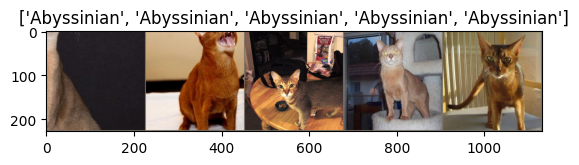

In [40]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

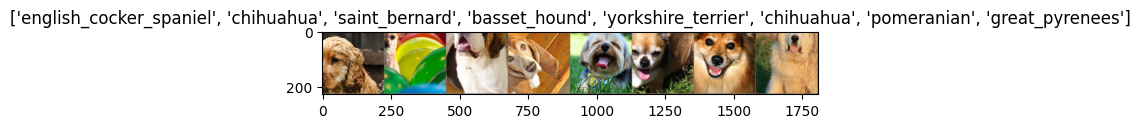

In [41]:
# Get a batch of training data
inputs, classes = next(iter(loader_train))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

## 2. Exercise: modifying VGG Model

The torchvision module comes with a zoo of popular CNN architectures which are already trained on [ImageNet](http://www.image-net.org/) (1.2M training images). When called the first time, if `pretrained=True` the model is fetched over the internet and downloaded to `~/.torch/models`.
For next calls, the model will be directly read from there.

In [42]:
model_vgg = models.vgg16(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 294MB/s]


In [43]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)

model_vgg = model_vgg.to(device)

In [44]:
outputs_try = model_vgg(inputs_try)

In [45]:
outputs_try

tensor([[-2.1511e+00, -3.0634e+00,  3.2816e-01,  ..., -1.3342e+00,
         -3.6884e-01,  2.1560e+00],
        [-4.7902e+00, -2.8912e+00, -2.8305e+00,  ..., -3.4478e+00,
          3.8947e-01,  3.6783e+00],
        [-4.7026e-01, -8.3542e-01, -1.2108e+00,  ..., -1.4044e+00,
          7.0880e-03,  2.4170e+00],
        [ 2.9069e-01, -1.0044e+00,  1.1407e+00,  ..., -4.9076e+00,
          4.3777e-01,  2.7948e+00],
        [-1.9073e+00,  2.3107e+00, -2.0235e+00,  ..., -7.6831e+00,
          4.2254e+00,  2.0954e+00]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [46]:
outputs_try.shape

torch.Size([5, 1000])

### Modifying the last layer and setting the gradient false to all layers

In [47]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

![vgg16](https://dataflowr.github.io/notebooks/Module1/img/vgg16.png)

Here, our goal is to use the already trained model and just change the number of output classes. To this end we replace the last ```nn.Linear``` layer trained for 1000 classes to ones with 37 classes. In order to freeze the weights of the other layers during training, we set the field ```required_grad=False```. In this manner no gradient will be computed for them during backprop and hence no update in the weights. Only the weights for the 37-class layer will be updated.

PyTorch documentation for [LogSoftmax](https://pytorch.org/docs/stable/nn.html#logsoftmax)

In [48]:
for param in model_vgg.parameters():
    param.requires_grad = False
    
# your code here
model_vgg.classifier._modules['6'] = nn.Linear(4096,37)
model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim=1)



In [49]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=37, bias=True)
  (7): LogSoftmax(dim=1)
)


Once you modified the architecture of the network, do not forget to put in onto the device!

In [50]:
# your code here
model_vgg = model_vgg.to(device)


## Training fully connected module

### Creating loss function and optimizer

PyTorch documentation for [NLLLoss](https://pytorch.org/docs/stable/nn.html#nllloss) and the [torch.optim module](https://pytorch.org/docs/stable/optim.html#module-torch.optim)

In [51]:
criterion = nn.NLLLoss()
lr = 0.001
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)
## ok

### Training the model

In [52]:
def train_model(model,dataloader,size,epochs=1,optimizer=None):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in dataloader:
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            loss = criterion(outputs,classes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [53]:
%%time
train_model(model_vgg,loader_train,size=dset_sizes['train'],epochs=50,optimizer=optimizer_vgg)

Loss: 0.0509 Acc: 0.1554
Loss: 0.0368 Acc: 0.4715
Loss: 0.0285 Acc: 0.6389
Loss: 0.0236 Acc: 0.7111
Loss: 0.0200 Acc: 0.7563
Loss: 0.0176 Acc: 0.7850
Loss: 0.0159 Acc: 0.8089
Loss: 0.0148 Acc: 0.8133
Loss: 0.0136 Acc: 0.8305
Loss: 0.0126 Acc: 0.8386
Loss: 0.0120 Acc: 0.8498
Loss: 0.0114 Acc: 0.8566
Loss: 0.0110 Acc: 0.8498
Loss: 0.0106 Acc: 0.8555
Loss: 0.0102 Acc: 0.8605
Loss: 0.0098 Acc: 0.8607
Loss: 0.0093 Acc: 0.8749
Loss: 0.0091 Acc: 0.8689
Loss: 0.0090 Acc: 0.8763
Loss: 0.0088 Acc: 0.8774
Loss: 0.0085 Acc: 0.8735
Loss: 0.0083 Acc: 0.8790
Loss: 0.0082 Acc: 0.8787
Loss: 0.0081 Acc: 0.8733
Loss: 0.0080 Acc: 0.8828
Loss: 0.0077 Acc: 0.8812
Loss: 0.0075 Acc: 0.8855
Loss: 0.0075 Acc: 0.8869
Loss: 0.0073 Acc: 0.8828
Loss: 0.0072 Acc: 0.8926
Loss: 0.0071 Acc: 0.8926
Loss: 0.0070 Acc: 0.8899
Loss: 0.0069 Acc: 0.8921
Loss: 0.0070 Acc: 0.8910
Loss: 0.0067 Acc: 0.8932
Loss: 0.0066 Acc: 0.8940
Loss: 0.0065 Acc: 0.8937
Loss: 0.0064 Acc: 0.9005
Loss: 0.0065 Acc: 0.8932
Loss: 0.0064 Acc: 0.9046


In [54]:
def test_model(model,dataloader,size):
    model.eval()
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size,37))
    i = 0
    running_loss = 0.0
    running_corrects = 0
    #print(size)
    for inputs,classes in dataloader:
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,classes)           
        _,preds = torch.max(outputs.data,1)
            # statistics
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == classes.data)
        predictions[i:i+len(classes)] = preds.to('cpu').numpy()
        all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
        all_proba[i:i+len(classes),:] = outputs.data.to('cpu').numpy()
        i += len(classes)
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    return predictions, all_proba, all_classes

In [55]:
predictions, all_proba, all_classes = test_model(model_vgg,loader_valid,size=dset_sizes['test'])

Loss: 0.0603 Acc: 0.9332


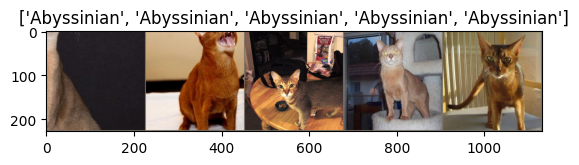

In [56]:
# Get a batch of training data
inputs, classes = next(iter(loader_valid))

out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

Compute the predictions made by your network for `inputs[:n_images]` and the associated probabilities.

Hint: use `torch.max` and `torch.exp`.

Do not forget to put your inputs on the device!

In [57]:
# your code here
outputs = model_vgg(inputs[:n_images].to(device))
print(torch.exp(outputs))
vals_try, preds_try = torch.max(outputs.data, 1)# your code here


tensor([[3.1617e-01, 1.2733e-02, 3.2386e-03, 8.5569e-03, 2.8768e-02, 1.6389e-02,
         4.9154e-03, 3.3467e-03, 5.4177e-03, 1.0588e-01, 3.1038e-02, 8.1609e-02,
         4.6797e-02, 4.6743e-02, 2.4143e-02, 1.8837e-02, 4.7777e-02, 1.5526e-02,
         3.7074e-03, 3.6106e-03, 1.2779e-02, 4.5490e-03, 3.2711e-03, 3.2321e-03,
         3.6370e-03, 6.8941e-03, 2.3477e-02, 3.5549e-03, 2.0312e-03, 3.2464e-02,
         7.4131e-03, 3.7352e-03, 5.5064e-03, 2.3247e-02, 2.2073e-02, 1.4692e-02,
         2.2363e-03],
        [6.8487e-01, 2.3474e-02, 5.9155e-04, 1.7882e-02, 3.1815e-03, 1.2509e-03,
         1.7817e-03, 3.5415e-04, 7.6836e-04, 7.2828e-03, 2.1759e-02, 6.0680e-03,
         6.4318e-04, 8.9987e-03, 1.3083e-03, 2.3908e-03, 8.3213e-03, 2.7523e-02,
         2.3679e-03, 7.0190e-04, 4.2691e-03, 6.5887e-04, 5.3327e-04, 1.6574e-03,
         6.9529e-04, 1.6781e-03, 1.4231e-01, 7.4987e-04, 6.3956e-04, 2.3951e-03,
         1.3393e-03, 7.3083e-04, 1.4778e-03, 8.6860e-03, 7.3135e-03, 9.4397e-04,
      

In [58]:
preds_try

tensor([0, 0, 0, 0, 0], device='cuda:0')

In [59]:
classes[:n_images]

tensor([0, 0, 0, 0, 0])

In [60]:
torch.exp(vals_try)

tensor([0.3162, 0.6849, 0.4534, 0.7991, 0.8794], device='cuda:0')

## Speeding up the learning by precomputing features

In [61]:
def preconvfeat(dataloader):
    conv_features = []
    labels_list = []
    for data in dataloader:
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [62]:
%%time
conv_feat_train,labels_train = preconvfeat(loader_train)

CPU times: user 8.78 s, sys: 1.13 s, total: 9.91 s
Wall time: 10.6 s


In [63]:
conv_feat_train.shape

(3669, 512, 7, 7)

In [64]:
%%time
conv_feat_valid,labels_valid = preconvfeat(loader_valid)

CPU times: user 12.3 s, sys: 1.45 s, total: 13.8 s
Wall time: 14.2 s


### Creating a new data generator

We will not load images anymore, so we need to build our own data loader.

In [65]:
dtype=torch.float
datasetfeat_train = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_train,labels_train)]
datasetfeat_train = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_train]
loaderfeat_train = torch.utils.data.DataLoader(datasetfeat_train, batch_size=128, shuffle=True)

Now you can train for more epochs.

In [66]:
%%time
train_model(model_vgg.classifier,dataloader=loaderfeat_train,size=dset_sizes['train'],epochs=80,optimizer=optimizer_vgg)

Loss: 0.0029 Acc: 0.9098
Loss: 0.0029 Acc: 0.8986
Loss: 0.0029 Acc: 0.8997
Loss: 0.0028 Acc: 0.9128
Loss: 0.0028 Acc: 0.9109
Loss: 0.0028 Acc: 0.9052
Loss: 0.0029 Acc: 0.9062
Loss: 0.0028 Acc: 0.9128
Loss: 0.0028 Acc: 0.9101
Loss: 0.0028 Acc: 0.9114
Loss: 0.0027 Acc: 0.9054
Loss: 0.0027 Acc: 0.9054
Loss: 0.0027 Acc: 0.9106
Loss: 0.0028 Acc: 0.9081
Loss: 0.0027 Acc: 0.9101
Loss: 0.0026 Acc: 0.9125
Loss: 0.0027 Acc: 0.9095
Loss: 0.0026 Acc: 0.9103
Loss: 0.0027 Acc: 0.9131
Loss: 0.0026 Acc: 0.9158
Loss: 0.0026 Acc: 0.9068
Loss: 0.0026 Acc: 0.9117
Loss: 0.0026 Acc: 0.9144
Loss: 0.0027 Acc: 0.9027
Loss: 0.0026 Acc: 0.9147
Loss: 0.0026 Acc: 0.9114
Loss: 0.0026 Acc: 0.9133
Loss: 0.0026 Acc: 0.9111
Loss: 0.0026 Acc: 0.9163
Loss: 0.0025 Acc: 0.9180
Loss: 0.0026 Acc: 0.9158
Loss: 0.0026 Acc: 0.9133
Loss: 0.0025 Acc: 0.9131
Loss: 0.0025 Acc: 0.9152
Loss: 0.0025 Acc: 0.9120
Loss: 0.0025 Acc: 0.9161
Loss: 0.0025 Acc: 0.9144
Loss: 0.0025 Acc: 0.9191
Loss: 0.0025 Acc: 0.9152
Loss: 0.0026 Acc: 0.9128


In [67]:
datasetfeat_valid = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_valid,labels_valid)]
datasetfeat_valid = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_valid]
loaderfeat_valid = torch.utils.data.DataLoader(datasetfeat_valid, batch_size=128, shuffle=False)

Now you can compute the accuracy on the test set.

In [68]:
predictions, all_proba, all_classes = test_model(model_vgg.classifier,dataloader=loaderfeat_valid,size=dset_sizes['test'])

Loss: 0.0018 Acc: 0.9490


## Confusion matrix

For 37 classes, plotting a confusion matrix is useful to see the performance of the algorithm per class.

In [69]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 45.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [70]:
from sklearn.metrics import confusion_matrix
import itertools
def make_fig_cm(cm):
    fig = plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    tick_marks = np.arange(37);
    plt.xticks(tick_marks, dset_classes, rotation=90);
    plt.yticks(tick_marks, dset_classes, rotation=0);
    plt.tight_layout();
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        coeff = f'{cm[i, j]}'
        plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual');
    plt.xlabel('Predicted');

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [71]:
cm = confusion_matrix(all_classes,predictions)

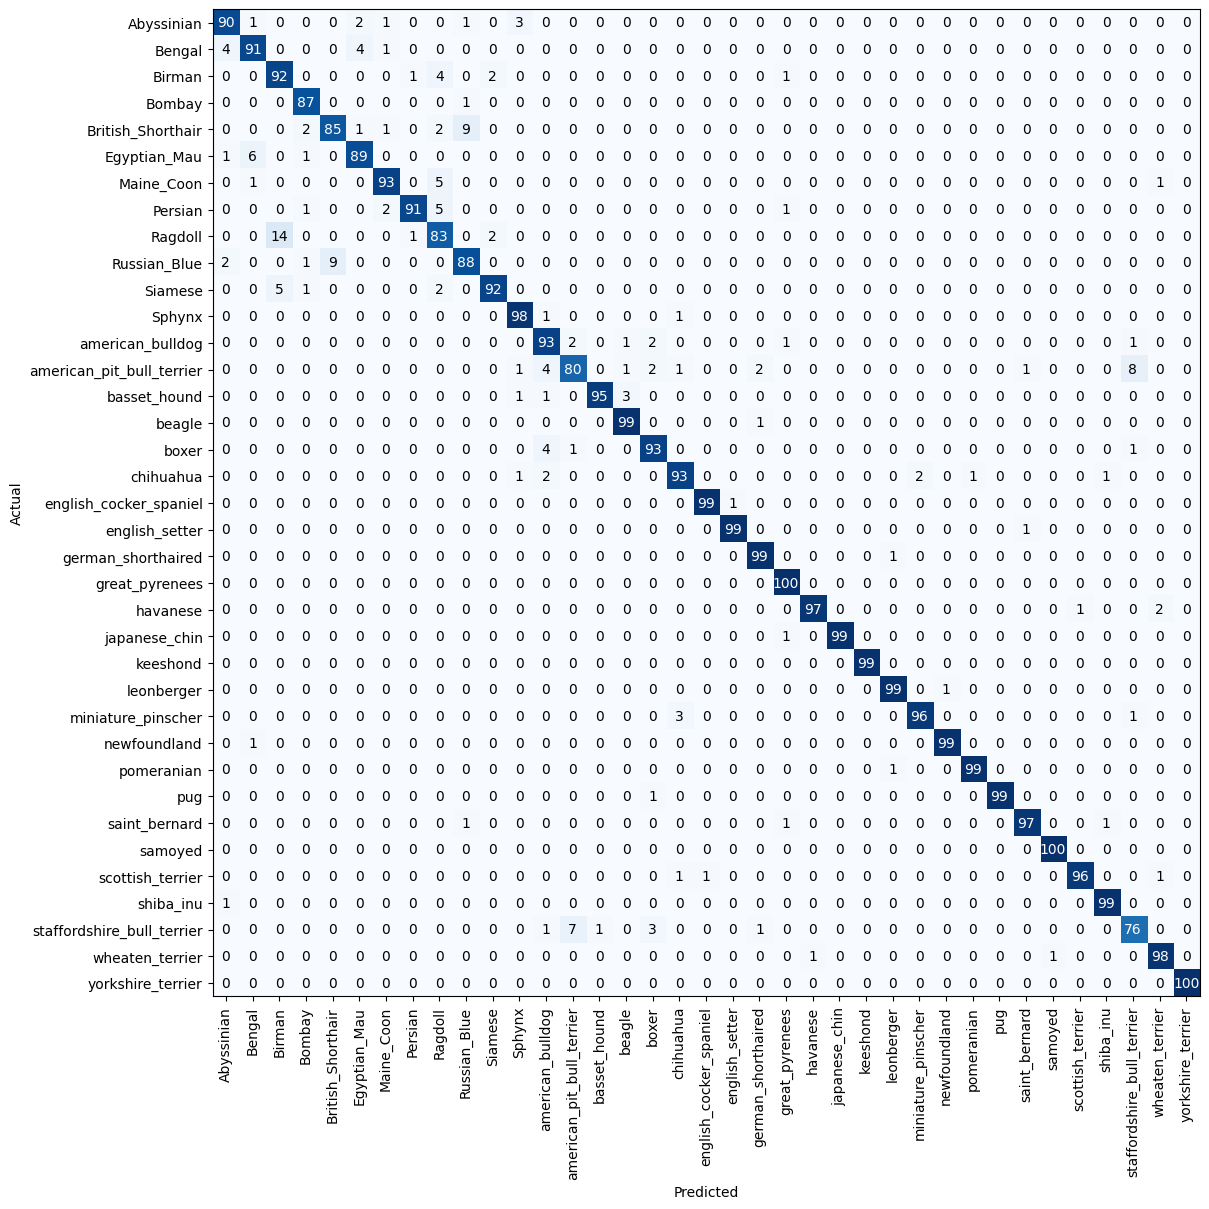

In [72]:
make_fig_cm(cm)

Here, you see that [american pit bull terrier](https://en.wikipedia.org/wiki/American_Pit_Bull_Terrier) are often predicted as [staffordshire bull terrier](https://en.wikipedia.org/wiki/Staffordshire_Bull_Terrier) but overall your algorithm should give pretty good results!

## 3. Exercise: change of neural network model

Great! So far, you reproduced the result of the first lesson. Now, you will need to take another model. I propose to take a `resnet34` from the list availabel [here](https://pytorch.org/docs/stable/torchvision/models.html)

__Note__ the main purpose of this exercise is to lean how to modify a network. We do not really care about performances...

In [73]:
model_resnet = models.resnet34(weights='DEFAULT') # your code here

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 301MB/s]


In [74]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

OK, the strucutre is quite different from the one of VGG we saw during the course but we still see that the last layer is a Linear layer taking a vector of size 512 and producing a vector of size 1000 (i.e. the number of classes in Imagenet). Hence you should be able to modify this network for your classification task with 37 classes!

First freeze the weights of your model and replace the last layer by a Linear layer with the appropriate size.

In [75]:
# your code here
print(model_resnet.fc)

Linear(in_features=512, out_features=1000, bias=True)


Now we need to add the LogSoftmax layer. Follow the instructions [here](https://discuss.pytorch.org/t/how-to-add-an-additional-layer-on-top-of-a-pretrained-model/21303/2) to add this layer

In [76]:
# model_resnet_lsm = # your code here
model_resnet.eval()
for param in model_resnet.parameters():
    param.requires_grad = False

model_resnet.fc = nn.Linear(512,37)

In [77]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Check that everything is working fine!

In [78]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)
model_resnet = model_resnet.to(device)
outputs_try = model_resnet(inputs_try)

In [79]:
outputs_try.shape

torch.Size([5, 37])

Now you can start training.

You will take the same loss as before: [NLLLoss](https://pytorch.org/docs/stable/nn.html#nllloss) but you need to modify the argument of the optimizer [torch.optim module](https://pytorch.org/docs/stable/optim.html#module-torch.optim)

In [80]:
#Hint print(model_resnet_lsm[0].fc)
model_resnet = nn.Sequential(model_resnet, torch.nn.LogSoftmax(dim=1))
lr = 0.001
optimizer_resnet = torch.optim.SGD(model_resnet[0].fc.parameters(),lr = lr ) #your code here


Now you can use the same function as above for the training loop.

In [81]:
%%time
train_model(model_resnet,loader_train,size=dset_sizes['train'],epochs=90,optimizer=optimizer_resnet)

Loss: 0.0579 Acc: 0.0425
Loss: 0.0547 Acc: 0.0788
Loss: 0.0521 Acc: 0.1322
Loss: 0.0498 Acc: 0.2118
Loss: 0.0476 Acc: 0.2963
Loss: 0.0455 Acc: 0.3644
Loss: 0.0434 Acc: 0.4399
Loss: 0.0416 Acc: 0.4811
Loss: 0.0398 Acc: 0.5328
Loss: 0.0381 Acc: 0.5710
Loss: 0.0365 Acc: 0.6162
Loss: 0.0350 Acc: 0.6359
Loss: 0.0336 Acc: 0.6661
Loss: 0.0323 Acc: 0.6893
Loss: 0.0310 Acc: 0.7046
Loss: 0.0299 Acc: 0.7261
Loss: 0.0288 Acc: 0.7326
Loss: 0.0277 Acc: 0.7443
Loss: 0.0268 Acc: 0.7561
Loss: 0.0259 Acc: 0.7640
Loss: 0.0251 Acc: 0.7719
Loss: 0.0243 Acc: 0.7800
Loss: 0.0237 Acc: 0.7850
Loss: 0.0229 Acc: 0.7986
Loss: 0.0223 Acc: 0.7999
Loss: 0.0217 Acc: 0.8010
Loss: 0.0211 Acc: 0.8076
Loss: 0.0206 Acc: 0.8136
Loss: 0.0202 Acc: 0.8174
Loss: 0.0196 Acc: 0.8149
Loss: 0.0191 Acc: 0.8269
Loss: 0.0188 Acc: 0.8305
Loss: 0.0182 Acc: 0.8269
Loss: 0.0178 Acc: 0.8310
Loss: 0.0175 Acc: 0.8332
Loss: 0.0171 Acc: 0.8392
Loss: 0.0168 Acc: 0.8433
Loss: 0.0166 Acc: 0.8446
Loss: 0.0163 Acc: 0.8441
Loss: 0.0160 Acc: 0.8485


In [82]:
%%time
predictions, all_proba, all_classes = test_model(model_resnet,loader_valid,size=dset_sizes['test'])

Loss: 0.1088 Acc: 0.9032
CPU times: user 6.83 s, sys: 1.07 s, total: 7.9 s
Wall time: 8.44 s


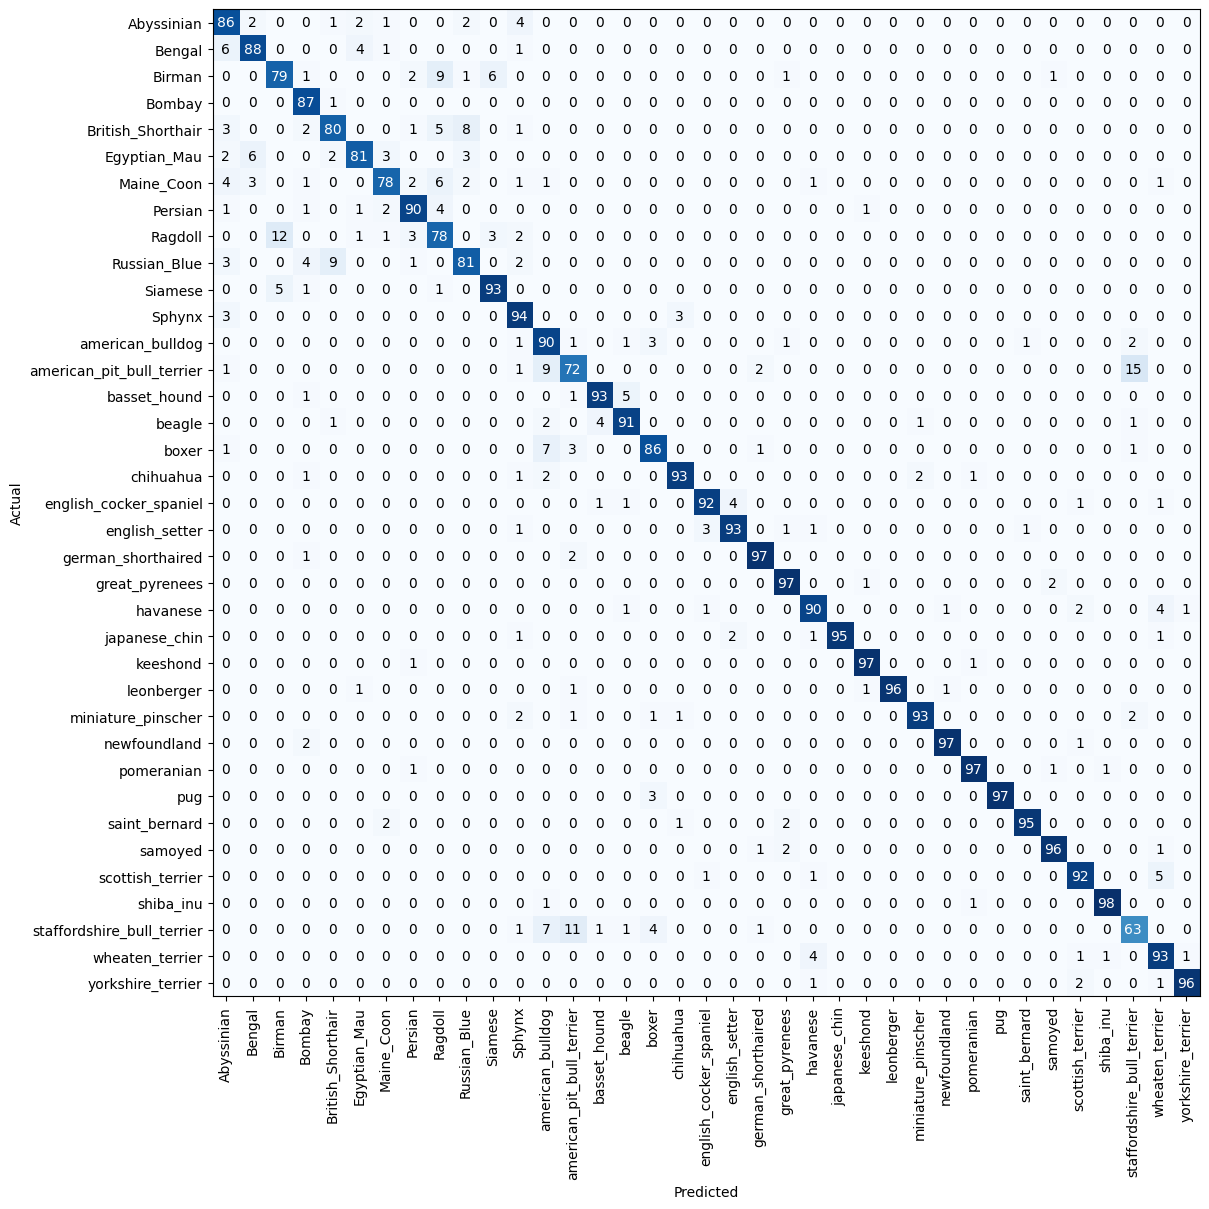

In [83]:
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)

## Well done!

What would you do to speed up the process in the last part?

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)